### Conexión a ruta de Proyecto

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/PROYECTOS_DIPLOMADO/VISION

/content/drive/MyDrive/PROYECTOS_DIPLOMADO/VISION


In [ ]:
!ls

'Copy of U-NET_JOSE.ipynb'
'Copy of U-NET_JOSE_labels.ipynb'
'Copy of U-NET_JOSE_mas_epocas.ipynb'
'Copy of Untitled0_JOSE.ipynb'
'Copy of YOLO_JOSE.ipynb'
 dataset_profa
 datasets
 GoogleNet_DAR_1.ipynb
 GoogleNet_DAR.ipynb
 GoogleNet.ipynb
 GoogleNet_JIMM_1.ipynb
 MobileNet_DAR_1.ipynb
 MobileNet.ipynb
 Mobilenet_JIMM_1.ipynb
 models
'Proyecto de Visión Artificial - Segmentación y Clasificación de Árboles.gslides'
 ResNet_DAR_1.ipynb
 Resnet_JIMM_1.ipynb
 runs
 U-NET_JOSE.ipynb
 unet_model.pth
 unet_model_seg_4.pth
 unet_model_seg.pth
 unet_model_seg_weights_4.pth
 unet_model_seg_weights.pth
 unet_model_weights.pth
 Untitled0.ipynb
 Untitled0_JOSE.ipynb
 urban-street_-tree-classification-DatasetNinja
 urban-street_-tree-DatasetNinja
 YOLO2
 YOLO_JOSE.ipynb
 yolov8n.pt
 yolov8s.pt


### Librerías

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from PIL import Image, UnidentifiedImageError
import os
import json
import numpy as np
import base64
from io import BytesIO
import zlib
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU
import matplotlib.pyplot as plt
import cv2

### Clase TreeDataset

In [ ]:
path_dataset = 'urban-street_-tree-DatasetNinja'

In [ ]:
import json

with open(path_dataset + '/meta.json') as f:
    metadata = json.load(f)

classes = {(i): cls['title'] for i, cls in enumerate(metadata['classes'])}
num_classes = len(classes)   # +1 para el fondo
#classes[0] = 'background'

print(f"Número de clases: {num_classes}")
print(f"Clases: {classes}")

Número de clases: 22
Clases: {0: 'acer_palmatum', 1: 'cedrus_deodara', 2: 'celtis_sinensis', 3: 'cinnamomum_camphora_(linn)_presl', 4: 'elaeocarpus_decipiens', 5: 'flowering_cherry', 6: 'ginkgo_biloba', 7: 'koelreuteria_paniculata', 8: 'liquidambar_formosana', 9: 'liriodendron_chinense', 10: 'magnolia_grandiflora_l', 11: 'magnolia_liliflora_desr', 12: 'michelia_chapensis', 13: 'osmanthus_fragrans', 14: 'photinia_serratifolia', 15: 'platanus', 16: 'prunus_cerasifera_f._atropurpurea', 17: 'salix_babylonica', 18: 'sapindus_saponaria', 19: 'styphnolobium_japonicum', 20: 'triadica_sebifera', 21: 'zelkova_serrata'}


In [ ]:
len(classes)

22

In [ ]:
# Define TreeDataset
class TreeDataset(Dataset):
    def __init__(self, root, classes, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "img"))))
        self.anns = list(sorted(os.listdir(os.path.join(root, "ann"))))
        self.classes = classes
        self.class_to_idx = {v: k for k, v in classes.items()}

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "img", self.imgs[idx])
        ann_path = os.path.join(self.root, "ann", self.anns[idx])

        img = Image.open(img_path).convert("RGB")
        with open(ann_path) as f:
            ann = json.load(f)

        height, width = ann['size']['height'], ann['size']['width']
        masks = np.zeros((len(self.classes), height, width), dtype=np.float32)
        for obj in ann['objects']:
            mask = self.create_mask_from_bitmap(obj['bitmap'], height, width)
            class_idx = self.class_to_idx[obj['classTitle']]
            masks[class_idx] = mask

        img = np.array(img).astype(np.float32) / 255.0

        if self.transforms:
            # Aplicar transformaciones a la imagen
            transformed = self.transforms(image=img)
            img = transformed['image']
            #print(img.shape)

            # Obtener el tamaño de la imagen transformada
            transformed_height, transformed_width = img.shape[1], img.shape[2]
            #print(f"Transformed height: {transformed_height}, Transformed width: {transformed_width}")
            #print(f"Original height: {height}, Original width: {width}")

            # Redimensionar las máscaras según las dimensiones de la imagen transformada
            transformed_masks = np.zeros((len(self.classes), transformed_height, transformed_width), dtype=np.float32)
            for class_idx in range(len(self.classes)):
                mask = masks[class_idx]
                transformed_mask = self.resize_mask(mask, (height, width), (transformed_height, transformed_width))
                transformed_masks[class_idx] = transformed_mask

            #print(f"Transformed masks shape: {transformed_masks.shape}")
            # Convertir las máscaras a tensores PyTorch
            masks = transformed_masks

        # Convertir img y masks a tensores de PyTorch
        #img = torch.tensor(img).permute(2, 0, 1)  # Convertir a CHW
        masks = torch.tensor(masks)

        target = {"masks": masks}

        return img, target

    def __len__(self):
        return len(self.imgs)

    def create_mask_from_bitmap(self, bitmap, height, width):
        try:
            bitmap_data = bitmap['data']
            if isinstance(bitmap_data, str):
                bitmap_data = base64.b64decode(bitmap_data)

            compressed, decompressed_data = self.is_compressed(bitmap_data)
            if compressed:
                bitmap_data = decompressed_data

            image = Image.open(BytesIO(bitmap_data))
            mask = np.array(image)

            mask_resized = np.zeros((height, width), dtype=np.uint8)
            x, y = bitmap['origin']
            mask_resized[y:y + mask.shape[0], x:x + mask.shape[1]] = mask

            return mask_resized
        except (base64.binascii.Error, UnidentifiedImageError) as e:
            print(f"Error al procesar la imagen: {e}")
            print(f"Datos del bitmap: {bitmap['data']}")
            return np.zeros((height, width), dtype=np.uint8)

    def is_compressed(self, data):
        try:
            decompressed_data = zlib.decompress(data)
            return True, decompressed_data
        except zlib.error:
            return False, None

    def resize_mask(self, mask, original_size, transformed_size):
        # Redimensionar la máscara para que coincida con el tamaño de la imagen transformada
        original_height, original_width = original_size
        transformed_height, transformed_width = transformed_size

        # Escalar la máscara utilizando interpolación bilineal
        resized_mask = Image.fromarray(mask).resize((transformed_width, transformed_height), resample=Image.BILINEAR)
        resized_mask = np.array(resized_mask)

        return resized_mask

    def get_classes(self):
        return self.classes

    def get_class_to_idx(self):
        return self.class_to_idx

    def get_num_classes(self):
        return self.num_classes

    def get_img_path(self, idx):
        return os.path.join(self.root, "img", self.imgs[idx])

    def get_ann_path(self, idx):
        return os.path.join(self.root, "ann", self.anns[idx])

    def get_img_shape(self, idx):
        img_path = self.get_img_path(idx)
        img = Image.open(img_path).convert("RGB")
        return img.size

    def get_total_images(self):
        return len(self.imgs)

    def get_random_img_path(self):
        idx = np.random.randint(len(self.imgs))
        return self.get_img_path(idx)

    def get_random_ann_path(self):
        idx = np.random.randint(len(self.anns))
        return self.get_ann_path(idx)

    def get_random_img_and_ann_paths(self):
        idx = np.random.randint(len(self.imgs))
        img_path = self.get_img_path(idx)
        ann_path = self.get_ann_path(idx)
        return img_path, ann_path

    def get_img_and_mask(self, idx):
        img, target = self.__getitem__(idx)
        return img, target

    def get_random_img_and_mask(self):
        idx = np.random.randint(len(self.imgs))
        img, target = self.__getitem__(idx)
        return img, target

    def get_random_img(self):
        img_path = self.get_random_img_path()
        img = Image.open(img_path).convert("RGB")
        return img

### Carga de Dataset y Preprocesamiento

In [ ]:
def get_transform(train):
    if train:
        return A.Compose([
            A.Resize(height=1024, width=768),  # Ajusta el tamaño de la imagen y máscara a 512x512
            A.RandomBrightnessContrast(p=0.2),  # Brillo/contraste aleatorio con probabilidad 0.2
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(height=1024, width=768),
            ToTensorV2()
        ])


# Create datasets and dataloaders
dataset_train = TreeDataset(os.path.join(path_dataset, 'train'), classes, get_transform(train=True))
dataset_val = TreeDataset(os.path.join(path_dataset, 'val'), classes, get_transform(train=False))
dataset_test = TreeDataset(os.path.join(path_dataset, 'test'), classes, get_transform(train=False))

data_loader_train = DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
data_loader_val = DataLoader(dataset_val, batch_size=8, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
data_loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

(8, 3, 1024, 768)
(1024, 768, 3)
min: 0.0
max: 1.0
Masks shape: (22, 1024, 768)
Mask 0 shape: (1024, 768)
Mask 1 shape: (1024, 768)
Mask 2 shape: (1024, 768)
Mask 3 shape: (1024, 768)
Mask 4 shape: (1024, 768)
Mask 5 shape: (1024, 768)
Mask 6 shape: (1024, 768)
Mask 7 shape: (1024, 768)
Mask 8 shape: (1024, 768)
Mask 9 shape: (1024, 768)
Mask 10 shape: (1024, 768)
Mask 11 shape: (1024, 768)
Mask 12 shape: (1024, 768)
Mask 13 shape: (1024, 768)
Mask 14 shape: (1024, 768)
Mask 15 shape: (1024, 768)
Mask 16 shape: (1024, 768)
Mask 17 shape: (1024, 768)
Mask 18 shape: (1024, 768)
Mask 19 shape: (1024, 768)
Mask 20 shape: (1024, 768)
Mask 21 shape: (1024, 768)


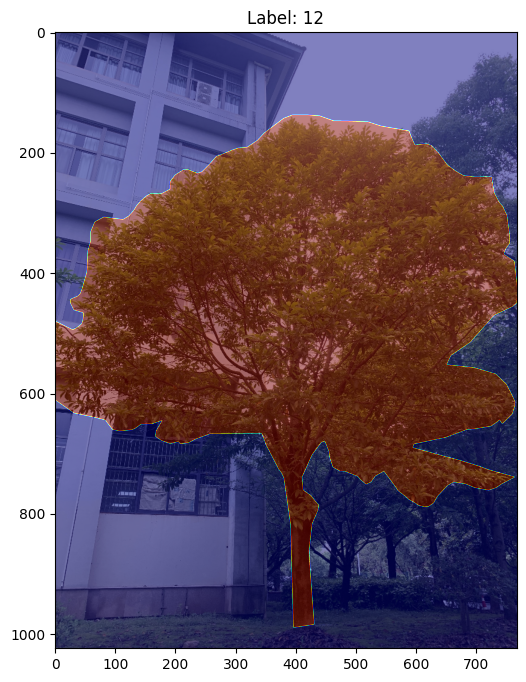

In [ ]:
# Visualizar las imágenes y las máscaras
for imgs, targets in data_loader_train:
    print(np.shape(imgs))
    for img, target in zip(imgs, targets):
        img = img.permute(1, 2, 0).numpy()  # Reordenar los ejes del tensor para que sean compatibles con matplotlib
        print(img.shape)
        # img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Desnormalizar la imagen
        # img = np.clip(img, 0, 1)  # Asegurarse de que los valores estén en el rango [0, 1]
        # img = (img * 255).astype(np.uint8)
        print('min:', img.min())
        print('max:', img.max())

        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(img)

        # Dibujar las máscaras
        masks = target['masks'].numpy()
        print("Masks shape:", masks.shape)  # Imprimir la forma de las máscaras para debug

        # Si las máscaras solo tienen una capa, ajustar en consecuencia
        if masks.ndim == 3:  # Caso típico de máscaras con múltiples clases (C, H, W)
            for i in range(masks.shape[0]):
                mask = masks[i, :, :]
                print(f"Mask {i} shape:", mask.shape)
                if mask.max() > 0:  # Visualizar solo si hay alguna predicción en la máscara
                    ax.imshow(mask, alpha=0.5, cmap='jet')
                    ax.set_title(f"Label: {i}")
        elif masks.ndim == 2:  # Caso de una sola capa de máscara (H, W)
            ax.imshow(masks, alpha=0.5, cmap='jet')
            ax.set_title("Single mask layer")

        plt.show()
        break  # Mostrar solo el primer batch para evitar demasiadas visualizaciones
    break

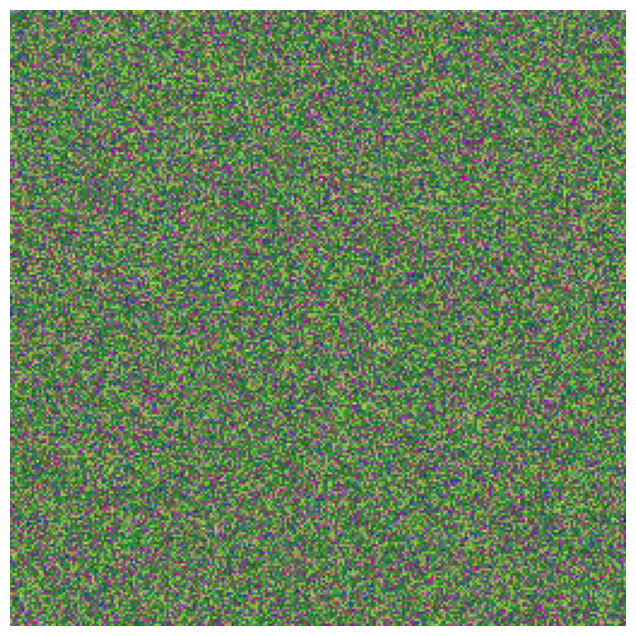

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_masks_overlaid(image, masks):
    """
    Visualiza la imagen superpuesta con las máscaras de diferentes clases.

    Args:
    - image (numpy.array): La imagen original en formato numpy.
    - masks (numpy.array): Las máscaras combinadas en formato numpy (num_classes, height, width).

    Returns:
    - None, muestra la imagen superpuesta con matplotlib.
    """
    num_classes, height, width = masks.shape

    # Crear una imagen en blanco para superponer las máscaras
    overlaid_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Colores aleatorios para cada clase
    colormap = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_classes)]

    # Superponer las máscaras
    for class_idx in range(1, num_classes):  # Empezamos desde 1 para omitir el fondo (background)
        mask = masks[class_idx]
        color = colormap[class_idx]
        overlaid_image[mask > 0] = color

    # Normalizar la imagen original para mostrarla correctamente en matplotlib
    image = (image * 255).astype(np.uint8)

    # Visualizar la imagen superpuesta con matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.imshow(overlaid_image, alpha=0.7)
    plt.axis('off')
    plt.show()

# Ejemplo de uso
# Suponiendo que image y masks son obtenidos del dataset
image = np.random.rand(256, 256, 3)  # Ejemplo de imagen aleatoria
masks = np.random.randint(0, 2, size=(23, 256, 256))  # Ejemplo de máscaras binarias (num_classes, height, width)

# Visualizar la imagen superpuesta con las máscaras
visualize_masks_overlaid(image, masks)


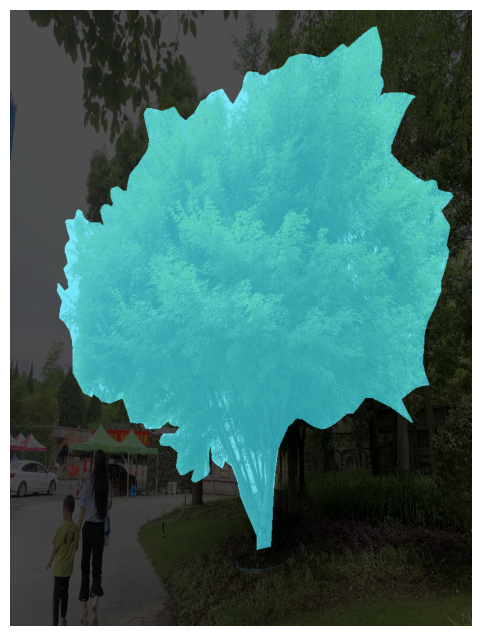

In [ ]:
# Visualizar las imágenes y las máscaras
for imgs, targets in data_loader_train:
    for img, target in zip(imgs, targets):
        img = img.permute(1, 2, 0).numpy()  # Reordenar los ejes del tensor para que sean compatibles con matplotlib
        # img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Desnormalizar la imagen
        # img = np.clip(img, 0, 1)  # Asegurarse de que los valores estén en el rango [0, 1]
        #img = (img * 255).astype(np.uint8)

        visualize_masks_overlaid(img, target['masks'].numpy())
        break  # Mostrar solo el primer batch para evitar demasiadas visualizaciones
    break

### Transfer Learning

In [ ]:
import torch
import segmentation_models_pytorch as smp

# Definir el número de clases para la segmentación

# Cargar un modelo U-Net preentrenado con pesos de Imagenet
model = smp.Unet(
    encoder_name="resnet34",  # Puedes cambiar el backbone por otro compatible
    encoder_weights="imagenet",  # Usar pesos preentrenados de Imagenet
    in_channels=3,  # Entradas con 3 canales (imágenes RGB)
    classes=1,  # Número de clases de salida
)

# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Imprimir la estructura del modelo
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

###Entrenamiento

In [ ]:


def compute_dice(pred, target, epsilon=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    dice = (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)
    return dice.item()


In [ ]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
)
model = model.to(device)

# Congelar todos los parámetros del modelo
for param in model.parameters():
    param.requires_grad = False

# Descongelar los parámetros de los últimos layers
for param in model.decoder.parameters():
    param.requires_grad = True

# También puedes descongelar el último bloque del encoder
for param in model.encoder.layer4.parameters():
    param.requires_grad = True

learning_rate = 0.001
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Listas para almacenar las métricas
train_losses = []
val_losses = []
val_ious = []
val_dices = []

# Training loop
num_epochs = 2

iou_metric = IoU(threshold=0.5)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in data_loader_train:
        imgs, targets = batch
        imgs = torch.stack(imgs).to(device)  # Apilar imágenes en un tensor y enviar a dispositivo
        masks = torch.stack([t["masks"] for t in targets]).float().to(device)  # Convertir a tipo Long para la máscara

        # Verificar las dimensiones de imgs, masks y labels
        print('imgs shape:', imgs.shape)
        print('masks shape:', masks.shape)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        epoch_loss = running_loss / len(data_loader_train)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validación
    model.eval()
    val_loss = 0.0
    ious = []
    dices = []

    with torch.no_grad():
        for batch in data_loader_val:
            imgs, targets = batch
            imgs = torch.stack(imgs).to(device)  # Apilar imágenes en un tensor y enviar a dispositivo
            masks = torch.stack([t["masks"] for t in targets]).float().to(device)  # Convertir a tipo Long para la máscara

            # Forward pass
            outputs = model(imgs)

            # Calcular la pérdida
            loss = criterion(outputs, masks)

            val_loss += loss.item()

            # Calcular métricas
            preds = torch.sigmoid(outputs) > 0.5
            for pred, mask in zip(preds, masks):
                ious.append(iou_metric(pred, mask).item())
                dices.append(compute_dice(pred, mask))

    # Calcular promedio de métricas
    val_loss /= len(data_loader_val)
    val_losses.append(val_loss)
    val_ious.append(np.mean(ious))
    val_dices.append(np.mean(dices))
    print(f'Validation Loss: {val_loss:.4f}, IoU: {np.mean(ious):.4f}, Dice: {np.mean(dices):.4f}')

imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.0138
imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.0274
imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.0409
imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.0543
imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.0675
imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.0805
imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.0934
imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.1063
imgs shape: torch.Size([8, 3, 1024, 768])
masks shape: torch.Size([8, 22, 1024, 768])
Epoch 1/2, Loss: 0.1191
imgs shape

### Guardado del modelo

In [ ]:
torch.save(model.state_dict(), 'unet_model_weights.pth')

In [ ]:
torch.save(model, 'unet_model.pth')

###Se carga el modelo y visualiza una prediccion

In [ ]:
model = torch.load('unet_model.pth')

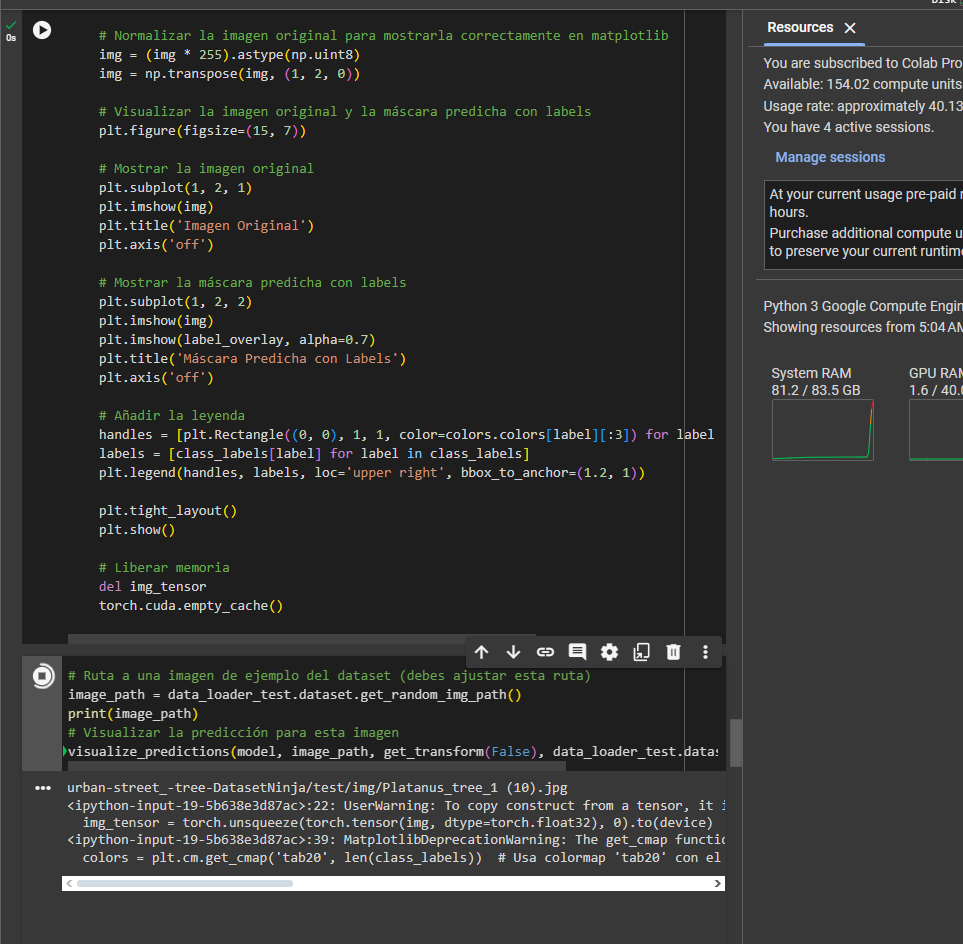

In [ ]:
# Al momento de ejecutar esta funcion, resultaba que la RAM del sistema se disparaba,
# como se puede ver en la imagen de arriba.
# Hemos intentado solucionar este problema, lamentablemente sin exito, sin embargo si se
# llego a entrenar y guardar la red
import torch.nn.functional as F

def visualize_predictions(model, image_path, transform, class_labels, top_n=3, threshold=0.5):
    """
    Visualiza las predicciones del modelo U-Net junto con la imagen original.

    Args:
    - model (torch.nn.Module): El modelo U-Net entrenado.
    - image_path (str): La ruta de la imagen del dataset.
    - transform (callable): Las transformaciones aplicadas a la imagen.
    - class_labels (dict): Diccionario de labels de clases {label: nombre}.
    """
    # Cargar la imagen
    img = Image.open(image_path).convert("RGB")
    img = np.array(img).astype(np.float32) / 255.0
    #print(img.shape)

    # Preprocesar la imagen
    transformed = transform(image=img)
    img = transformed['image']

    # Convertir la imagen a tensor y enviar al dispositivo adecuado
    img_tensor = torch.unsqueeze(torch.tensor(img, dtype=torch.float32), 0).to(device)
    #print(img_tensor.shape)
    # Realizar la predicción
    with torch.no_grad():
        output = model(img_tensor)

    # Obtener las probabilidades para cada clase
    probs = F.softmax(output.squeeze(), dim=0).cpu().numpy()

    # Obtener las top N clases más probables
    top_classes = np.argsort(probs, axis=0)[-top_n:]

    # Crear una imagen RGB para visualizar la máscara con los labels
    height, width = top_classes.shape[1:]
    label_overlay = np.zeros((height, width, 3), dtype=np.uint8)

    # Asignar colores a cada label
    colors = plt.cm.get_cmap('tab20', len(class_labels))  # Usa colormap 'tab20' con el número de clases
    for label in range(top_n):
        class_idx = top_classes[label]
        mask = probs[class_idx] > threshold  # Aplicar umbral
        label_overlay[mask] = np.array(colors.colors[class_idx][:3]) * 255

    # Normalizar la imagen original para mostrarla correctamente en matplotlib
    img = (np.array(img) * 255).astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))
    #print(img.shape)

    # Visualizar la imagen original y la máscara predicha con labels
    plt.figure(figsize=(15, 7))

    # Mostrar la imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Imagen Original')
    plt.axis('off')

    # Mostrar la máscara predicha con labels
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(label_overlay, alpha=0.7)
    plt.title('Máscara Predicha con Labels')
    plt.axis('off')

    # Añadir la leyenda
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors.colors[label][:3]) for label in class_labels]
    labels = [class_labels[label] for label in class_labels]
    plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()

In [ ]:
import torch.nn.functional as F

def visualize_predictions(model, image_path, transform, class_labels, top_n=3, threshold=0.5):
    """
    Visualiza las predicciones del modelo U-Net junto con la imagen original.

    Args:
    - model (torch.nn.Module): El modelo U-Net entrenado.
    - image_path (str): La ruta de la imagen del dataset.
    - transform (callable): Las transformaciones aplicadas a la imagen.
    - class_labels (dict): Diccionario de labels de clases {label: nombre}.
    """
    # Cargar la imagen
    img = Image.open(image_path).convert("RGB")
    img = np.array(img).astype(np.float32) / 255.0
    #print(img.shape)

    # Preprocesar la imagen
    transformed = transform(image=img)
    img = transformed['image']

    # Convertir la imagen a tensor y enviar al dispositivo adecuado
    img_tensor = torch.unsqueeze(torch.tensor(img, dtype=torch.float32), 0).to(device)
    #print(img_tensor.shape)
    # Realizar la predicción
    with torch.no_grad():
        output = model(img_tensor)

    # Obtener las probabilidades para cada clase
    probs = F.softmax(output.squeeze(), dim=0).cpu().numpy()

    # Obtener las top N clases más probables
    top_classes = np.argsort(probs, axis=0)[-top_n:]

    # Crear una imagen RGB para visualizar la máscara con los labels
    height, width = top_classes.shape[1:]
    label_overlay = np.zeros((height, width, 3), dtype=np.uint8)

    # Asignar colores a cada label
    colors = plt.cm.get_cmap('tab20', len(class_labels))  # Usa colormap 'tab20' con el número de clases
    for label in range(top_n):
        class_idx = top_classes[label]
        mask = probs[class_idx] > threshold  # Aplicar umbral
        label_overlay[mask] = np.array(colors.colors[class_idx][:3]) * 255

    # Normalizar la imagen original para mostrarla correctamente en matplotlib
    img = (np.array(img) * 255).astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))
    #print(img.shape)

    # Visualizar la imagen original y la máscara predicha con labels
    plt.figure(figsize=(15, 7))

    # Mostrar la imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Imagen Original')
    plt.axis('off')

    # Mostrar la máscara predicha con labels
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(label_overlay, alpha=0.7)
    plt.title('Máscara Predicha con Labels')
    plt.axis('off')

    # Añadir la leyenda
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors.colors[label][:3]) for label in class_labels]
    labels = [class_labels[label] for label in class_labels]
    plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()

In [ ]:
import torch.nn.functional as F

def visualize_predictions(model, image_path, transform, class_labels, top_n=3, threshold=0.5, device='cuda'):
    """
    Visualiza las predicciones del modelo U-Net junto con la imagen original.

    Args:
    - model (torch.nn.Module): El modelo U-Net entrenado.
    - image_path (str): La ruta de la imagen del dataset.
    - transform (callable): Las transformaciones aplicadas a la imagen.
    - class_labels (dict): Diccionario de labels de clases {label: nombre}.
    """
    # Cargar la imagen
    img = Image.open(image_path).convert("RGB")
    img = np.array(img).astype(np.float32) / 255.0

    # Preprocesar la imagen
    transformed = transform(image=img)
    img = transformed['image']

    # Convertir la imagen a tensor y enviar al dispositivo adecuado
    img_tensor = torch.unsqueeze(torch.tensor(img, dtype=torch.float32), 0).to(device)

    # Realizar la predicción
    with torch.no_grad():
        output = model(img_tensor)

    # Obtener las probabilidades para cada clase
    probs = F.softmax(output.squeeze(), dim=0).cpu().numpy()

    # Obtener las top N clases más probables
    top_classes = np.argsort(probs, axis=0)[-top_n:]

    # Crear una imagen RGB para visualizar la máscara con los labels
    height, width = img.shape[1:]
    label_overlay = np.zeros((height, width, 3), dtype=np.uint8)

    # Asignar colores a cada label
    colors = plt.cm.get_cmap('tab20', len(class_labels))  # Usa colormap 'tab20' con el número de clases
    for label in range(top_n):
        class_idx = top_classes[label]
        mask = probs[class_idx] > threshold  # Aplicar umbral
        label_overlay[mask] = np.array(colors.colors[class_idx][:3]) * 255

    # Normalizar la imagen original para mostrarla correctamente en matplotlib
    img = (img * 255).astype(np.uint8)
    img = np.transpose(img, (1, 2, 0))

    # Visualizar la imagen original y la máscara predicha con labels
    plt.figure(figsize=(15, 7))

    # Mostrar la imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Imagen Original')
    plt.axis('off')

    # Mostrar la máscara predicha con labels
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(label_overlay, alpha=0.7)
    plt.title('Máscara Predicha con Labels')
    plt.axis('off')

    # Añadir la leyenda
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors.colors[label][:3]) for label in class_labels]
    labels = [class_labels[label] for label in class_labels]
    plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()

    # Liberar memoria
    del img_tensor
    torch.cuda.empty_cache()
